# Mercari NLP

In [1]:
#Standard imports
import pandas as pd
import os
import sys
import string
import re
import numpy as np

#Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#SKlearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#NLTK
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, sent_tokenize
from nltk import WordNetLemmatizer # lemmatizer using WordNet
from nltk.corpus import wordnet # imports WordNet
from nltk import pos_tag # nltk's native part of speech tagging

In [2]:
import pyLDAvis.sklearn # a specialized package for topic model visualization

/Users/javm/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/javm/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [3]:
#modeling and dimensionality reduction for visuaization
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

## Preproccessing

In [4]:
train_df = pd.read_csv("/Users/javm/Desktop/Mercari-Price-Prediction-Project/vad")

In [5]:
train_df.isna().value_counts().sum()

250000

In [6]:
train_df['category_name'].value_counts()

Women Athletic Apparel Pants, Tights, Leggings                     19459
Women Tops & Blouses T-Shirts                                      14657
Beauty Makeup Face                                                 11412
Beauty Makeup Lips                                                  9928
Beauty Makeup Eyes                                                  8305
Electronics Video Games & Consoles Games                            8206
Electronics Cell Phones & Accessories Cases, Covers & Skins         7916
Women Underwear Bras                                                6919
Women Dresses Above Knee, Mini                                      6444
Women Tops & Blouses Tank, Cami                                     6424
Women Tops & Blouses Blouse                                         6389
Women Jewelry Necklaces                                             6346
Beauty Makeup Makeup Palettes                                       6246
Women Athletic Apparel Shorts                      

In [7]:
def process_text(clean_text, min_length):
    
    stop_words = stopwords.words('english')
    wnl = WordNetLemmatizer()
    
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
        
    clean_lower = clean_text.lower()

#     #remove mentions, hashtags, and urls, strip whitspace and breaks
#     tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    
    # remove stop words and punctuations 
    text_norm = [x for x in word_tokenize(clean_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(text_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
        text_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
        return text_norm


In [8]:
train_df['category_topic'] = train_df['category_name'].apply(process_text, args = [1])

In [9]:
train_df_new = train_df[train_df['category_topic'] != '']

In [10]:
train_df_new

,name,item_condition_id,category_name,price,shipping,item_description,brand_mention_True,compound_sentiment_desc,category_topic
0,Nike air max! Size 13 in men,3,Men Shoes Athletic,46.0,1,Great color blue navy and gold! In great condi...,1,0.8925,men shoe athletic
1,On Hold For Chelsie Bower,3,Women Sweaters Hooded,28.0,0,Ladies XL Under Armour Storm Hoodie Like new c...,1,0.0772,woman sweater hood
2,OASICS GEL RUNNING SHOES 8,4,Women Shoes Athletic,16.0,0,Barely used shoes but still works,1,0.0000,woman shoe athletic
3,2 bracelets,2,Women Jewelry Bracelets,45.0,1,Juste du Clau ( nail bracelets) is rose gold.....,1,0.6380,woman jewelry bracelet
4,Very Sexy 32dd Crystal Push Up Bra,1,Women Underwear Bras,24.0,0,Victoria's Secret BNWT Red rhinestone crystals...,1,0.8122,woman underwear bra
...,...,...,...,...,...,...,...,...,...
249995,Rae Dunn I woke up like this,1,Home Kitchen & Dining Coffee & Tea Accessories,34.0,0,New set of two mugs Will ship with bubble wrap...,1,0.8364,home kitchen din coffee tea accessory
249996,⚡free shipping bebe top⚡,3,Women Tops & Blouses Blouse,10.0,1,Size S in great condition. Authentic There's a...,1,0.8442,woman top blouse blouse
249997,Michael Kors boots size 7,3,Women Shoes Boots,40.0,1,Brown leather Gold hardware Worn one time but ...,1,0.2960,woman shoe boot
249998,Clemson shirt,2,Women Tops & Blouses T-Shirts,14.0,0,Women's clemson shirt Size medium Never worn,0,0.2235,woman top blouse


In [11]:
tf_vec = TfidfVectorizer()
category_transformed = tf_vec.fit_transform(train_df_new['category_topic'])
category_transformed

<250000x81 sparse matrix of type '<class 'numpy.float64'>'
	with 934785 stored elements in Compressed Sparse Row format>

In [12]:
len(tf_vec.get_feature_names())

81

In [13]:
from sklearn.decomposition import NMF

In [14]:
topic_model = NMF(n_components = 5)
topic_model.fit(category_transformed)

NMF(n_components=5)

In [15]:
# to get H
H = topic_model.transform(category_transformed) # transform document into topic vector representation

# to get W 
W = topic_model.components_ # word component weights for each topic

print("Shape of W is " + str(W.shape))
print("Shape of H is " + str(H.shape))
print("Shape of X_train is " + str(category_transformed.shape))

Shape of W is (5, 81)
Shape of H is (250000, 5)
Shape of X_train is (250000, 81)


In [16]:
for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([tf_vec.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['slim', 'skinny', 'hood', 'crossbody', 'messenger', 'tot', 'handbags', 'shopper', 'sweater', 'bag', 'shoulder', 'accessory', 'handbag', 'swimwear', 'fragrance', 'athletic', 'wallet', 'apparel', 'shirt', 'men', 'tank', 'cami', 'woman', 'top', 'blouse']


THE TOP 10 WORDS FOR TOPIC #1
['crossbody', 'cover', 'doll', 'handbags', 'handbag', 'girl', 'game', 'din', 'fashion', 'figure', 'electronics', 'earring', 'décor', 'dress', 'woman', 'body', 'skin', 'fragrance', 'care', 'palette', 'eye', 'lip', 'face', 'beauty', 'makeup']


THE TOP 10 WORDS FOR TOPIC #2
['electronics', 'action', 'eye', 'face', 'fashion', 'figure', 'fragrance', 'accessory', 'game', 'doll', 'boot', 'shoe', 'men', 'bra', 'top', 'sport', 'jacket', 'shirt', 'short', 'woman', 'pant', 'tights', 'legging', 'athletic', 'apparel']


THE TOP 10 WORDS FOR TOPIC #3
['sweater', 'fashion', 'sneaker', 'bag', 'shoulder', 'swimwear', 'wallet', 'ring', 'handbag', 'fragrance', 'earring', 'men', 'knee', 'mini', 

In [17]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(20, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 18})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 5
tfidf_feature_names = tf_vec.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in Mercari Dataset")

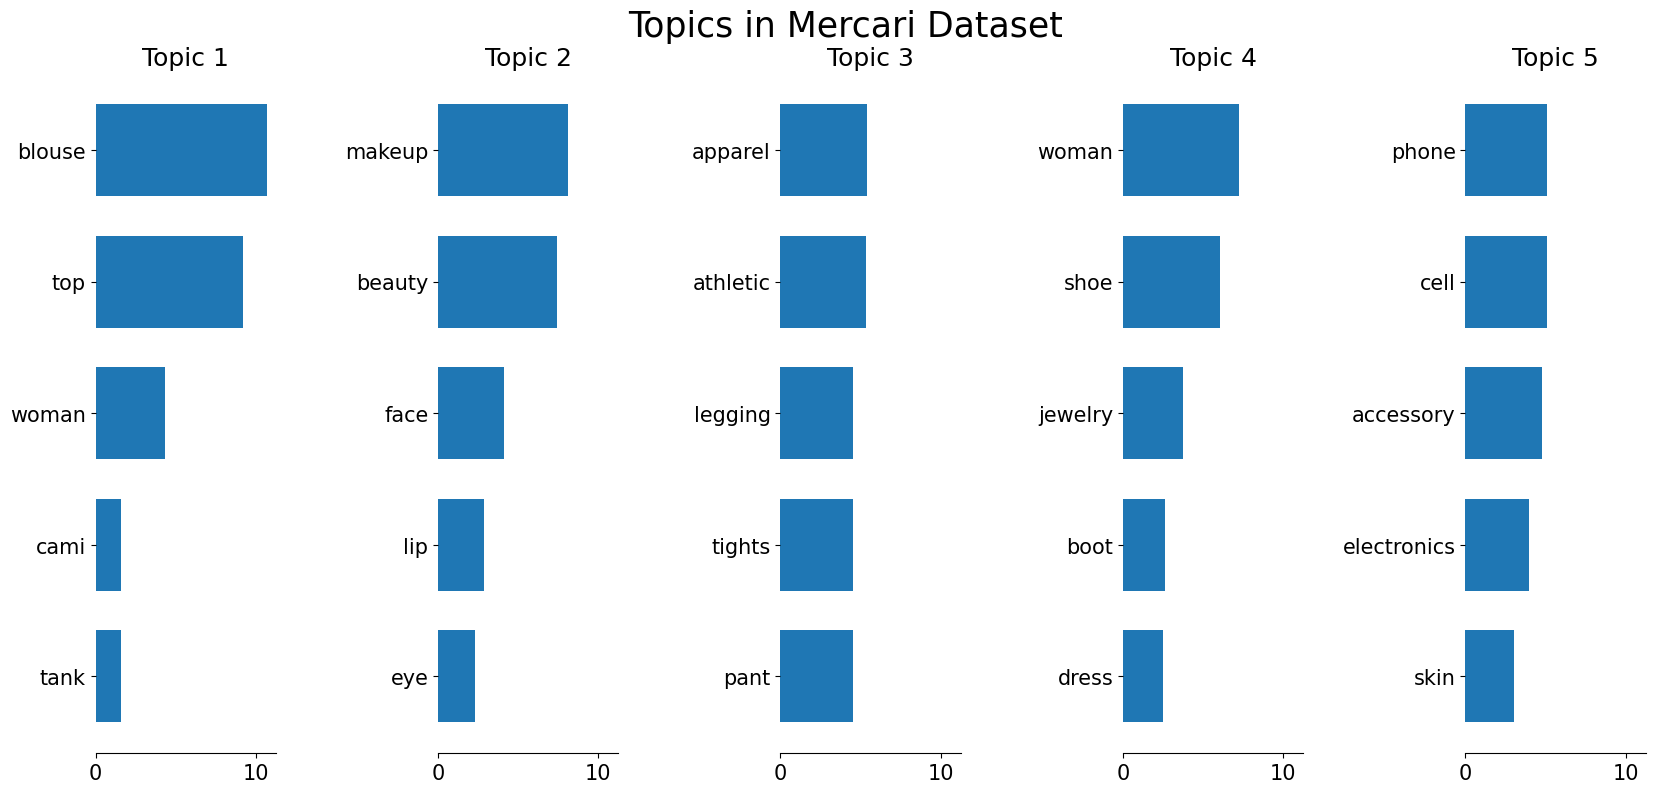

In [18]:
topic_word_plot()

In [19]:
topic_name_dict = {0: 'clothing', 1: 'beauty products', 2: "women's clothing", 3: 'accessories', 4: 'electronics'}

In [20]:
tsne = TSNE(learning_rate=100)
tsne_trans = tsne.fit_transform(H)
tsne_trans = pd.DataFrame(tsne_trans, columns = ['TSNE1', 'TSNE2'])

/Users/javm/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/Users/javm/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:350: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np

In [21]:
tsne_trans['class'] = np.argmax(H, axis = 1)
tsne_trans['class'] = tsne_trans['class'].replace(topic_name_dict)

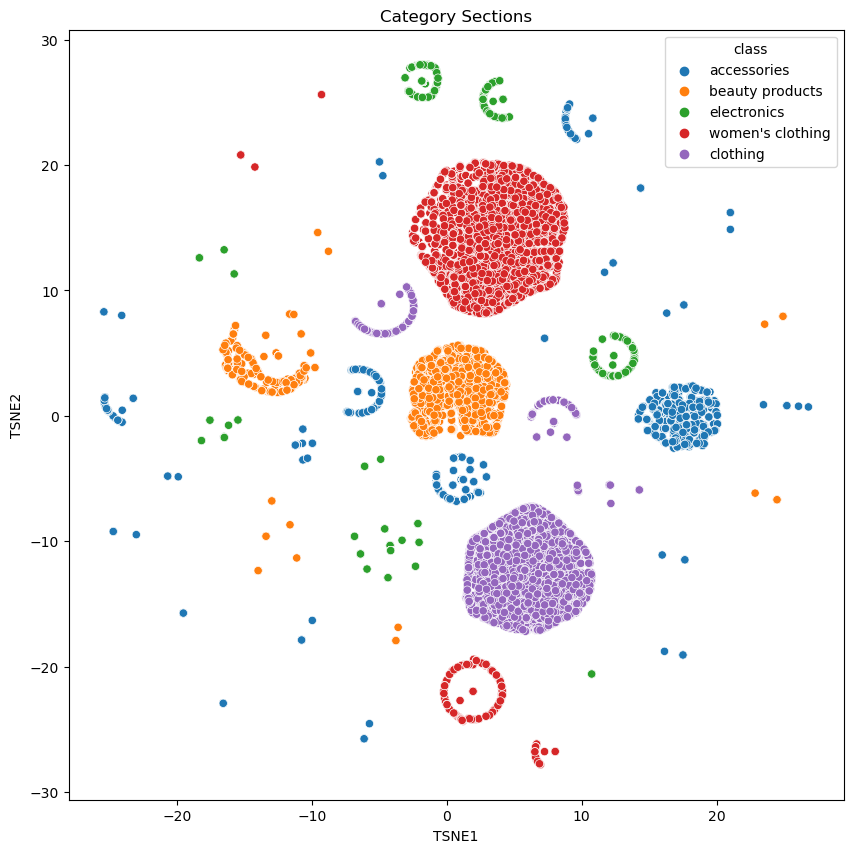

In [22]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans, palette = 'tab10')
plt.title('Category Sections')
plt.show()

In [23]:
H_repres_norm = pd.DataFrame(H, columns = topic_name_dict.values(), index = train_df_new.index)
H_repres_norm = H_repres_norm.divide(H_repres_norm.sum(axis=1), axis=0)

In [24]:
H_repres_norm.head()

,clothing,beauty products,women's clothing,accessories,electronics
0,0.000000,0.0,0.308205,0.691795,0.0
1,0.131890,0.0,0.023092,0.845019,0.0
2,0.000000,0.0,0.295137,0.704863,0.0
3,0.000000,0.0,0.000000,1.000000,0.0
4,0.019099,0.0,0.000000,0.980901,0.0


In [25]:
topic_df = train_df.join(H_repres_norm)
topic_df

,name,item_condition_id,category_name,price,shipping,item_description,brand_mention_True,compound_sentiment_desc,category_topic,clothing,beauty products,women's clothing,accessories,electronics
0,Nike air max! Size 13 in men,3,Men Shoes Athletic,46.0,1,Great color blue navy and gold! In great condi...,1,0.8925,men shoe athletic,0.000000,0.0,0.308205,0.691795,0.000000
1,On Hold For Chelsie Bower,3,Women Sweaters Hooded,28.0,0,Ladies XL Under Armour Storm Hoodie Like new c...,1,0.0772,woman sweater hood,0.131890,0.0,0.023092,0.845019,0.000000
2,OASICS GEL RUNNING SHOES 8,4,Women Shoes Athletic,16.0,0,Barely used shoes but still works,1,0.0000,woman shoe athletic,0.000000,0.0,0.295137,0.704863,0.000000
3,2 bracelets,2,Women Jewelry Bracelets,45.0,1,Juste du Clau ( nail bracelets) is rose gold.....,1,0.6380,woman jewelry bracelet,0.000000,0.0,0.000000,1.000000,0.000000
4,Very Sexy 32dd Crystal Push Up Bra,1,Women Underwear Bras,24.0,0,Victoria's Secret BNWT Red rhinestone crystals...,1,0.8122,woman underwear bra,0.019099,0.0,0.000000,0.980901,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,Rae Dunn I woke up like this,1,Home Kitchen & Dining Coffee & Tea Accessories,34.0,0,New set of two mugs Will ship with bubble wrap...,1,0.8364,home kitchen din coffee tea accessory,0.000000,0.0,0.000000,0.032007,0.967993
249996,⚡free shipping bebe top⚡,3,Women Tops & Blouses Blouse,10.0,1,Size S in great condition. Authentic There's a...,1,0.8442,woman top blouse blouse,1.000000,0.0,0.000000,0.000000,0.000000
249997,Michael Kors boots size 7,3,Women Shoes Boots,40.0,1,Brown leather Gold hardware Worn one time but ...,1,0.2960,woman shoe boot,0.000000,0.0,0.000000,1.000000,0.000000
249998,Clemson shirt,2,Women Tops & Blouses T-Shirts,14.0,0,Women's clemson shirt Size medium Never worn,0,0.2235,woman top blouse,0.983723,0.0,0.000000,0.016277,0.000000


In [26]:
topic_df = topic_df.drop(columns = 'category_topic', axis = 1)

In [27]:
topic_df

,name,item_condition_id,category_name,price,shipping,item_description,brand_mention_True,compound_sentiment_desc,clothing,beauty products,women's clothing,accessories,electronics
0,Nike air max! Size 13 in men,3,Men Shoes Athletic,46.0,1,Great color blue navy and gold! In great condi...,1,0.8925,0.000000,0.0,0.308205,0.691795,0.000000
1,On Hold For Chelsie Bower,3,Women Sweaters Hooded,28.0,0,Ladies XL Under Armour Storm Hoodie Like new c...,1,0.0772,0.131890,0.0,0.023092,0.845019,0.000000
2,OASICS GEL RUNNING SHOES 8,4,Women Shoes Athletic,16.0,0,Barely used shoes but still works,1,0.0000,0.000000,0.0,0.295137,0.704863,0.000000
3,2 bracelets,2,Women Jewelry Bracelets,45.0,1,Juste du Clau ( nail bracelets) is rose gold.....,1,0.6380,0.000000,0.0,0.000000,1.000000,0.000000
4,Very Sexy 32dd Crystal Push Up Bra,1,Women Underwear Bras,24.0,0,Victoria's Secret BNWT Red rhinestone crystals...,1,0.8122,0.019099,0.0,0.000000,0.980901,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,Rae Dunn I woke up like this,1,Home Kitchen & Dining Coffee & Tea Accessories,34.0,0,New set of two mugs Will ship with bubble wrap...,1,0.8364,0.000000,0.0,0.000000,0.032007,0.967993
249996,⚡free shipping bebe top⚡,3,Women Tops & Blouses Blouse,10.0,1,Size S in great condition. Authentic There's a...,1,0.8442,1.000000,0.0,0.000000,0.000000,0.000000
249997,Michael Kors boots size 7,3,Women Shoes Boots,40.0,1,Brown leather Gold hardware Worn one time but ...,1,0.2960,0.000000,0.0,0.000000,1.000000,0.000000
249998,Clemson shirt,2,Women Tops & Blouses T-Shirts,14.0,0,Women's clemson shirt Size medium Never worn,0,0.2235,0.983723,0.0,0.000000,0.016277,0.000000


In [28]:
topic_df.to_csv('topic',index = False)

In [29]:
# 1. vader_df.to_csv('vad',index=False)
# 2. topic_df.to_csv('topic',index = False)